In [22]:
import pandas as pd
import numpy as np

# Load the data, require labels and features
df_train_set = pd.read_csv('data/train_judgments_clean.csv')
df_dev_set = pd.read_csv('data/dev_judgments_clean.csv')
df_train_set.head(5)

,identifier1,identifier2,lemma,dataset,language,judgments,median_judgment,mean_disagreement,cosine_similarity,concate_pca
0,1993-90-21,1996-76-21,机制,chiwug,Chinese,"[4.0, 4.0]",4.0,0.000000,0.989826,"[7.116290092468262, -3.032158851623535, 6.8822..."
1,2532889X_1979-04-07_01_283.tcf.xml-2-8,26120215_1966_09_30_01_114.tcf.xml-5-8,Titel,dwug_de,German,[2.0],2.0,0.000000,0.987733,"[2.9565556049346924, -4.419107437133789, 1.734..."
2,1979-60-5,1982-96-5,憋,chiwug,Chinese,"[3.0, 4.0]",3.5,1.000000,0.993946,"[11.750508308410645, -4.91840934753418, 10.838..."
3,fic_1835_7133.txt-220-75,nf_1839_747507.txt-497-7,grain_nn,dwug_en,English,[4.0],4.0,0.000000,0.992638,"[-4.4785614013671875, 5.978180408477783, -0.06..."
4,modern_corpus_spanish-703052-621,old_corpus_spanish-115182-200,periodista,dwug_es,Spanish,"[3.0, 4.0, 4.0]",4.0,0.666667,0.993789,"[-10.53207015991211, 14.458964347839355, 6.533..."


200912


Text(0, 0.5, 'median_judgment')

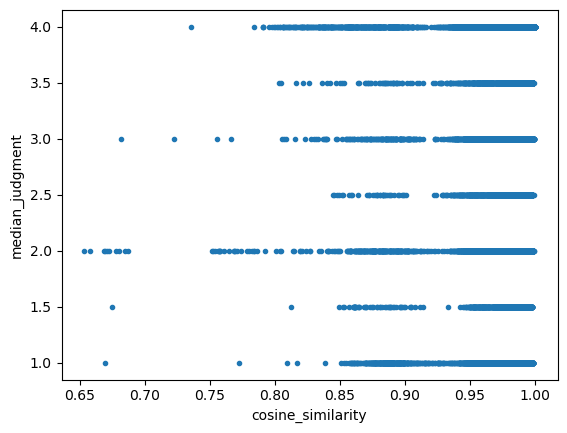

In [23]:
import matplotlib.pyplot as plt

print(len(df_train_set))
# project the cosine similarity with the proximity judgement
# df_train_set['cosine_similarity'] = -np.log(df_train_set['cosine_similarity'])
plt.plot(df_train_set['cosine_similarity'], df_train_set['median_judgment'], ".") 
plt.xlabel('cosine_similarity')
plt.ylabel('median_judgment')

200912


Text(0, 0.5, 'median_judgment')

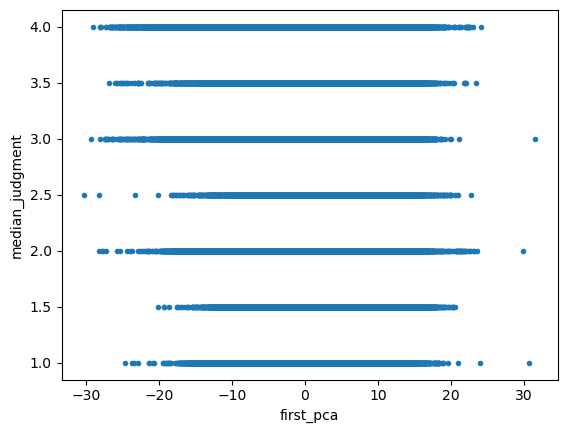

In [4]:
from ast import literal_eval

print(len(df_train_set))
# project the cosine similarity with the proximity judgement
df_train_set['concate_pca'] = df_train_set['concate_pca'].apply(literal_eval)
first_pca = df_train_set['concate_pca'].apply(lambda x: x[0])
plt.plot(first_pca, df_train_set['median_judgment'], ".") 
plt.xlabel('first_pca')
plt.ylabel('median_judgment')

In [17]:
import pickle
import cloudpickle
import arviz as az

# Load the linear model
pickle_filepath = f'pickle_concate.pkl'
with open(pickle_filepath , 'rb') as buff:
    model_dict = cloudpickle.load(buff)

trace = model_dict['trace']
model = model_dict['model']

az.summary(trace, kind='stats')

,mean,sd,hdi_3%,hdi_97%
a,2.575,0.544,1.716,2.915
b[0],-0.023,0.016,-0.050,-0.014
b[1],0.004,0.001,0.003,0.004
b[2],0.024,0.003,0.022,0.028
b[3],-0.028,0.004,-0.031,-0.022
b[4],-0.042,0.004,-0.044,-0.035
b[5],-0.008,0.003,-0.010,-0.007
b[6],-0.023,0.002,-0.024,-0.019
b[7],-0.002,0.003,-0.007,0.001
sigma,0.907,0.083,0.811,1.000


In [8]:
trace_df = trace.posterior.to_dataframe()
trace_df.cov().round(3)

,b,a,sigma
b,0.114,-9.863,0.014
a,-9.863,9827.608,-15.265
sigma,0.014,-15.265,0.026


In [ ]:
xbar = df_train_set['cosine_similarity'].mean()
plt.plot(df_train_set['cosine_similarity'], df_train_set['median_judgment'], ".")
plt.plot(
    df_train_set['cosine_similarity'],
    trace.posterior["a"].mean().item(0)
    + trace.posterior["b"].mean().item(0) * (df_train_set['cosine_similarity'] - xbar),
)
plt.xlabel('cosine_similarity')
plt.ylabel('median_judgment')

Text(0, 0.5, 'median_judgment')

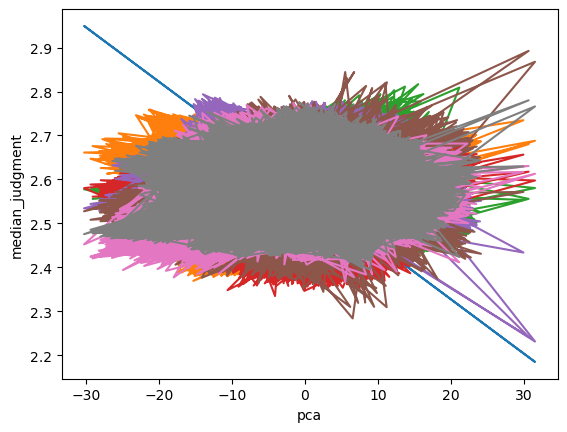

In [18]:
array = np.array(df_train_set['concate_pca'].tolist())
xbar = np.mean(array, axis=0)

# plt.plot(first_pca, df_train_set['median_judgment'], ".")
plt.plot(
    first_pca,
    trace.posterior["a"].mean().item(0)
    + (array - xbar).dot(trace.posterior["b"].mean()),
)
plt.xlabel('pca')
plt.ylabel('median_judgment')

In [10]:
import pymc as pm

samp_size = 1000
slice_rate = int(len(trace["posterior"]["draw"]) / samp_size)
thin_data = trace.sel(draw=slice(None, None, slice_rate))
xbar = df_dev_set['cosine_similarity'].mean()
with pm.Model() as WiC_predict:
    # priors
    a = pm.Normal("a", mu=0, sigma=4)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 1)

    mu = a + b * (df_dev_set['cosine_similarity'] - xbar)
    proximity = pm.Normal("proximity", mu=mu, sigma=sigma)
    
    proximity_pred = pm.sample_posterior_predictive(thin_data, var_names=['proximity'])
az.plot_hdi(df_dev_set['cosine_similarity'], proximity_pred.posterior_predictive["proximity"], hdi_prob=0.89)
plt.scatter(df_dev_set['cosine_similarity'], df_dev_set['median_judgment'])
plt.xlabel("cosine_similarity")
plt.ylabel("median_judgment")

ValueError: slice step cannot be zero

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00

Text(0, 0.5, 'median_judgment')

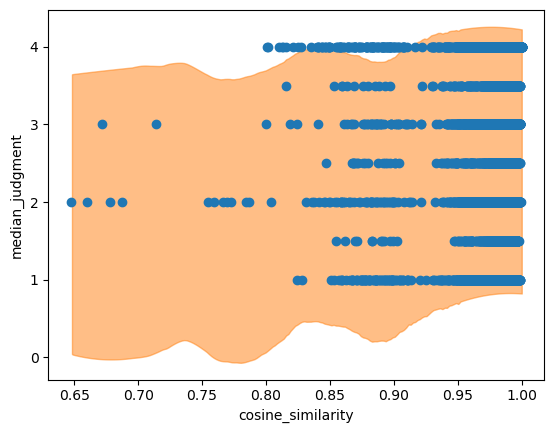

In [20]:
import pymc as pm

# samp_size = 1000
# slice_rate = int(len(trace["posterior"]["draw"]) / samp_size)
# thin_data = trace.sel(draw=slice(None, None, slice_rate))

array = np.array(df_dev_set['concate_pca'].apply(literal_eval).tolist())
xbar = np.mean(array, axis=0)

with pm.Model(coords={'features':[i for i in range(8)]}) as WiC_predict:
    # priors
    a = pm.Normal("a", mu=1, sigma=3)
    b = pm.Normal("b", mu=0, sigma=1, dims="features")
    sigma = pm.Uniform("sigma", 0, 1)
    
    # observed data
    xdata = pm.Data('xdata', array - xbar, mutable=True)
    mu = a + xdata.dot(b)
    print(mu.shape.eval())
    proximity = pm.Normal("proximity", mu=mu, sigma=sigma)
    
    proximity_pred = pm.sample_posterior_predictive(trace, var_names=['proximity'])
az.plot_hdi(df_dev_set['cosine_similarity'], proximity_pred.posterior_predictive["proximity"], hdi_prob=0.89)
plt.scatter(df_dev_set['cosine_similarity'], df_dev_set['median_judgment'])
plt.xlabel("cosine_similarity")
plt.ylabel("median_judgment")